# Model Quality Analysis

**Objective:** Evaluate the default prediction model quality through concrete cases and clear metrics.

In [1]:
import torch
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from Model.data import DataModule
from Model.network import Model
from Configs.config import config

pd.set_option('display.max_columns', 20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [2]:
project_root = os.getcwd()
data_path = os.path.join(project_root, config.paths.train_data)

runs_dir = os.path.join(project_root, "runs")
latest_run = sorted(os.listdir(runs_dir))[-1] if os.path.exists(runs_dir) else None
checkpoint_path = os.path.join(runs_dir, latest_run, "checkpoints", "best_model.pth")

print(f"Run: {latest_run}")
print(f"Checkpoint: {checkpoint_path}")

Run: 20260115_112150
Checkpoint: c:\Users\Victo\OneDrive\Área de Trabalho\Project-2\project - 2\runs\20260115_112150\checkpoints\best_model.pth


In [3]:
dm = DataModule(data_path, batch_size=config.model.batch_size)
dm.prepare_data()

model = Model(
    embedding_dims=dm.emb_dims, n_cont=len(dm.cont_cols),
    outcome_dim=config.model.outcome_dim, hidden_dim=config.model.hidden_dim,
    n_blocks=config.model.n_blocks, dropout=config.model.dropout, n_heads=config.model.n_heads,
    use_grn=config.model.use_grn, use_cross_attention=config.model.use_cross_attention
).to(device)

checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint
model.load_state_dict(state_dict)
model.eval()
print(f"Model loaded successfully - {sum(p.numel() for p in model.parameters()):,} params")

2026-01-15 11:35:04,809 - DataModule - INFO - Loading data from c:\Users\Victo\OneDrive\Área de Trabalho\Project-2\project - 2\Data/training_data.csv
2026-01-15 11:35:05,235 - DataModule - INFO - Categorical Features: 9
2026-01-15 11:35:05,235 - DataModule - INFO - Continuous Features: 17
2026-01-15 11:35:05,424 - DataModule - INFO - Random Split Strategy Implemented (seed=42)
2026-01-15 11:35:05,438 - DataModule - INFO - Class imbalance ratio (neg:pos): 24.8:1
2026-01-15 11:35:05,455 - DataModule - INFO - Using balanced sampling with target ratio: 30.0%
2026-01-15 11:35:05,455 - DataModule - INFO - Train Size: 55119
2026-01-15 11:35:05,455 - DataModule - INFO - Val Size: 11812
2026-01-15 11:35:05,455 - DataModule - INFO - Test Size: 11812
2026-01-15 11:35:05,455 - DataModule - INFO - Class Distribution - Train: 3.88% pos, Val: 3.97% pos, Test: 4.10% pos


Model loaded successfully - 124,586 params


In [4]:
preds, targets = [], []
with torch.no_grad():
    for x_cat, x_cont, y in dm.test_dataloader():
        logits = model(x_cat.to(device), x_cont.to(device))
        preds.append(torch.sigmoid(logits).cpu())
        targets.append(y.cpu())

y_prob = torch.cat(preds).view(-1).numpy()
y_true = torch.cat(targets).view(-1).numpy().astype(int)
y_pred = (y_prob > 0.5).astype(int)

print(f"Test samples: {len(y_true)}")
print(f"Actual defaults: {y_true.sum()} ({y_true.mean()*100:.1f}%)")

Test samples: 11812
Actual defaults: 484 (4.1%)


              precision    recall  f1-score   support

        Paid       0.99      0.41      0.58     11328
     Default       0.06      0.87      0.11       484

    accuracy                           0.43     11812
   macro avg       0.52      0.64      0.35     11812
weighted avg       0.95      0.43      0.56     11812


ROC-AUC: 0.7495


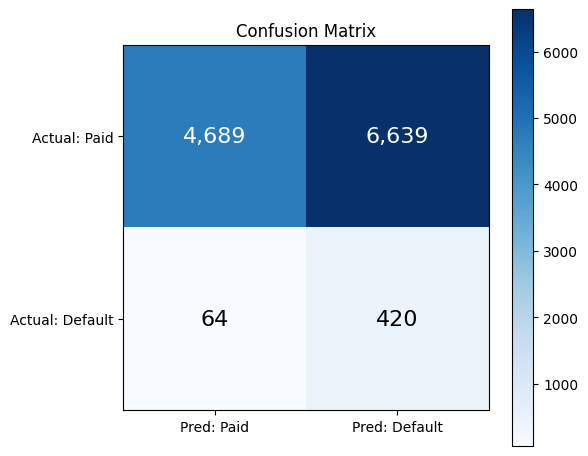


Interpretation:
   - True Negatives (Paid and predicted Paid): 4,689
   - False Positives (Paid but predicted Default): 6,639
   - False Negatives (Default but predicted Paid): 64 <- RISK
   - True Positives (Default and predicted Default): 420


In [5]:
print(classification_report(y_true, y_pred, target_names=['Paid', 'Default']))

print(f"\nROC-AUC: {roc_auc_score(y_true, y_prob):.4f}")

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(['Pred: Paid', 'Pred: Default'])
ax.set_yticklabels(['Actual: Paid', 'Actual: Default'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{cm[i,j]:,}', ha='center', va='center', fontsize=16, 
                color='white' if cm[i,j] > cm.max()/2 else 'black')
ax.set_title('Confusion Matrix')
plt.colorbar(im)
plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"   - True Negatives (Paid and predicted Paid): {cm[0,0]:,}")
print(f"   - False Positives (Paid but predicted Default): {cm[0,1]:,}")
print(f"   - False Negatives (Default but predicted Paid): {cm[1,0]:,} <- RISK")
print(f"   - True Positives (Default and predicted Default): {cm[1,1]:,}")

In [6]:
# Create test dataframe with predictions
# Note: Using random split, we work directly with prediction arrays
test_df = pd.DataFrame({
    'prob_default': y_prob,
    'pred_default': y_pred,
    'actual_default': y_true
})

print(f"Test data prepared: {len(test_df)} records")
print(f"Defaults: {test_df['actual_default'].sum()} ({test_df['actual_default'].mean()*100:.2f}%)")

# Simplified display columns (no original features available with random split)
cols_display = ['actual_default', 'prob_default', 'pred_default']

Test data prepared: 11812 records
Defaults: 484 (4.10%)


In [7]:
print("TRUE POSITIVES: Defaults correctly detected")
print("="*60)
tp = test_df[(test_df['actual_default'] == 1) & (test_df['prob_default'] > 0.5)]
print(f"Total: {len(tp)} cases\n")
if not tp.empty:
    display(tp.nlargest(5, 'prob_default')[cols_display].style.format({'prob_default': '{:.1%}'}))
else:
    print("No cases found.")

TRUE POSITIVES: Defaults correctly detected
Total: 420 cases



,actual_default,prob_default,pred_default
3449,1,94.7%,1
10292,1,94.3%,1
8796,1,93.7%,1
851,1,93.5%,1
9745,1,93.4%,1


In [8]:
# CASE 2: Defaults the model MISSED (False Negatives) - DANGEROUS
print("FALSE NEGATIVES: Missed defaults - HIGH RISK")
print("="*60)
fn = test_df[(test_df['actual_default'] == 1) & (test_df['prob_default'] <= 0.5)]
print(f"Total: {len(fn)} cases\n")
if not fn.empty:
    display(fn.nsmallest(5, 'prob_default')[cols_display].style.format({'prob_default': '{:.1%}'}))
else:
    print("No cases found - Great!")

FALSE NEGATIVES: Missed defaults - HIGH RISK
Total: 64 cases



,actual_default,prob_default,pred_default
1082,1,1.8%,0
4447,1,2.0%,0
4309,1,5.1%,0
8988,1,5.6%,0
2188,1,7.5%,0


In [9]:
# CASE 3: False Alarms (False Positives)
print("FALSE POSITIVES: Predicted default but actually paid")
print("="*60)
fp = test_df[(test_df['actual_default'] == 0) & (test_df['prob_default'] > 0.5)]
print(f"Total: {len(fp)} cases\n")
if not fp.empty:
    display(fp.nlargest(5, 'prob_default')[cols_display].style.format({'prob_default': '{:.1%}'}))
else:
    print("No cases found.")

FALSE POSITIVES: Predicted default but actually paid
Total: 6639 cases



,actual_default,prob_default,pred_default
9682,0,95.2%,1
5383,0,95.1%,1
95,0,94.2%,1
5623,0,94.2%,1
5989,0,93.8%,1


In [10]:
# Threshold analysis
print("THRESHOLD IMPACT ON DECISION")
print("="*60)

results = []
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, pred)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    results.append({
        'Threshold': f'{threshold:.0%}',
        'Defaults Detected': f'{tp}/{y_true.sum()} ({recall:.0%})',
        'False Alarms': fp,
        'Missed Defaults': fn,
        'Precision': f'{precision:.0%}'
    })

df_thresh = pd.DataFrame(results)
display(df_thresh)

print("\nInterpretation:")
print("   - LOW threshold (30%): Catches more defaults, but generates more false alarms")
print("   - HIGH threshold (70%): Fewer false alarms, but misses more defaults")

THRESHOLD IMPACT ON DECISION


,Threshold,Defaults Detected,False Alarms,Missed Defaults,Precision
0,30%,463/484 (96%),8579,21,5%
1,40%,448/484 (93%),7811,36,5%
2,50%,420/484 (87%),6639,64,6%
3,60%,378/484 (78%),4639,106,8%
4,70%,269/484 (56%),2351,215,10%
5,80%,92/484 (19%),457,392,17%



Interpretation:
   - LOW threshold (30%): Catches more defaults, but generates more false alarms
   - HIGH threshold (70%): Fewer false alarms, but misses more defaults


## 4. Specific User History

In [11]:
# User-level analysis not available with random split
# (original features like usuarioId are not preserved in test_df)
print("⚠️ User History Analysis")
print("="*60)
print("User-level analysis is not available when using random split,")
print("as original features (usuarioId, etc.) are not preserved.")
print("\nTo enable this analysis, you would need to:")
print("  1. Store the test set indices during data preparation")
print("  2. Map predictions back to original dataframe")
print("\nFor now, use the aggregate metrics and risk tier analysis above.")

⚠️ User History Analysis
User-level analysis is not available when using random split,
as original features (usuarioId, etc.) are not preserved.

To enable this analysis, you would need to:
  1. Store the test set indices during data preparation
  2. Map predictions back to original dataframe

For now, use the aggregate metrics and risk tier analysis above.


## 5. Final Summary

In [12]:
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
total_defaults = y_true.sum()
auc = roc_auc_score(y_true, y_prob)

print("="*60)
print("MODEL QUALITY SUMMARY")
print("="*60)
print(f"""
+-----------------------------------------------------------+
|  ROC-AUC Score: {auc:.4f}                                  |
+-----------------------------------------------------------+
|  Defaults in Test: {total_defaults:,} of {len(y_true):,} ({y_true.mean()*100:.1f}%)            |
+-----------------------------------------------------------+
|  Defaults Detected:  {tp:,} of {total_defaults:,} ({tp/total_defaults*100 if total_defaults > 0 else 0:.1f}%)               |
|  Defaults Missed:    {fn:,} of {total_defaults:,} ({fn/total_defaults*100 if total_defaults > 0 else 0:.1f}%)               |
|  False Alarms:       {fp:,}                                    |
+-----------------------------------------------------------+
""")

if auc >= 0.8:
    print("Model has GOOD discrimination capability")
elif auc >= 0.7:
    print("Model has MODERATE discrimination capability")
else:
    print("Model has LOW discrimination capability - needs improvement")

MODEL QUALITY SUMMARY

+-----------------------------------------------------------+
|  ROC-AUC Score: 0.7495                                  |
+-----------------------------------------------------------+
|  Defaults in Test: 484 of 11,812 (4.1%)            |
+-----------------------------------------------------------+
|  Defaults Detected:  420 of 484 (86.8%)               |
|  Defaults Missed:    64 of 484 (13.2%)               |
|  False Alarms:       6,639                                    |
+-----------------------------------------------------------+

Model has MODERATE discrimination capability


# Risk Score Analysis (Practical Usage)

Instead of binary classification, use the model as a **continuous risk scorer** for prioritization.

In [13]:
# Generate risk scores for ALL data (train + val + test)
def get_all_predictions(model, dm, device):
    """Generate risk scores for all datasets"""
    all_results = []
    
    for split_name, dataset in [('train', dm.train_dataset), 
                                 ('val', dm.val_dataset), 
                                 ('test', dm.test_dataset)]:
        loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)
        preds, targets = [], []
        
        with torch.no_grad():
            for x_cat, x_cont, y in loader:
                logits = model(x_cat.to(device), x_cont.to(device))
                preds.append(torch.sigmoid(logits).cpu())
                targets.append(y.cpu())
        
        probs = torch.cat(preds).view(-1).numpy()
        labels = torch.cat(targets).view(-1).numpy().astype(int)
        
        for i, (p, t) in enumerate(zip(probs, labels)):
            all_results.append({'split': split_name, 'risk_score': p, 'actual_default': t})
    
    return pd.DataFrame(all_results)

# Generate scores
risk_df = get_all_predictions(model, dm, device)
print(f"Total samples: {len(risk_df):,}")
print(f"Defaults: {risk_df['actual_default'].sum():,} ({risk_df['actual_default'].mean()*100:.2f}%)")

Total samples: 78,743
Defaults: 3,093 (3.93%)


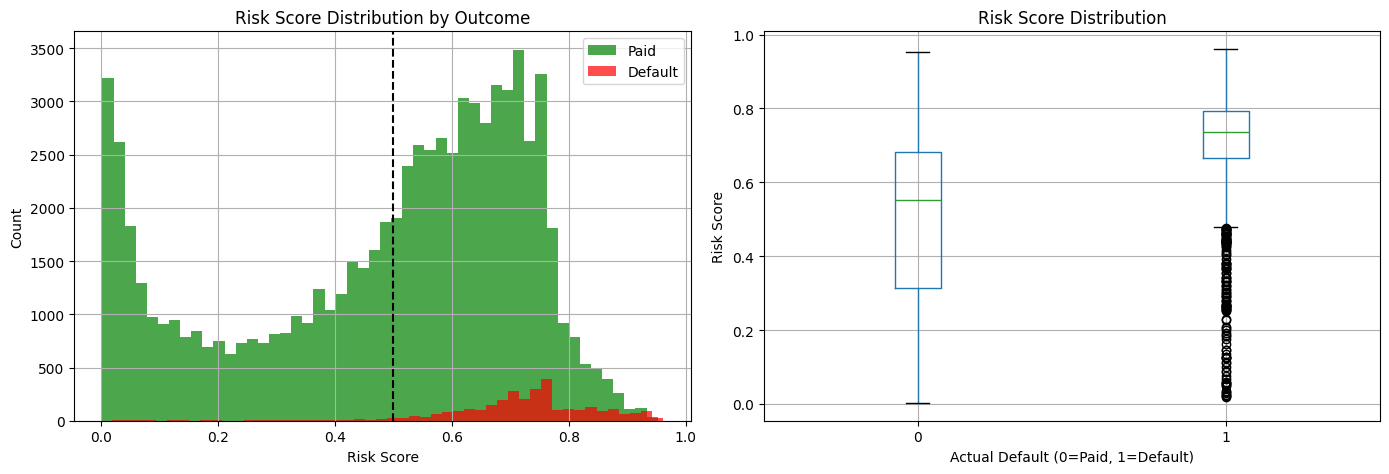


RISK SCORE STATISTICS

Paid:
  Mean:   0.4844
  Median: 0.5515
  Std:    0.2453
  Min:    0.0025
  Max:    0.9522

DEFAULT:
  Mean:   0.7199
  Median: 0.7350
  Std:    0.1323
  Min:    0.0183
  Max:    0.9607


In [14]:
# Risk Score Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution by actual outcome
ax1 = axes[0]
risk_df[risk_df['actual_default']==0]['risk_score'].hist(bins=50, alpha=0.7, label='Paid', ax=ax1, color='green')
risk_df[risk_df['actual_default']==1]['risk_score'].hist(bins=50, alpha=0.7, label='Default', ax=ax1, color='red')
ax1.set_xlabel('Risk Score')
ax1.set_ylabel('Count')
ax1.set_title('Risk Score Distribution by Outcome')
ax1.legend()
ax1.axvline(x=0.5, color='black', linestyle='--', label='Threshold 0.5')

# Boxplot
ax2 = axes[1]
risk_df.boxplot(column='risk_score', by='actual_default', ax=ax2)
ax2.set_xlabel('Actual Default (0=Paid, 1=Default)')
ax2.set_ylabel('Risk Score')
ax2.set_title('Risk Score Distribution')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "="*60)
print("RISK SCORE STATISTICS")
print("="*60)
for outcome in [0, 1]:
    subset = risk_df[risk_df['actual_default']==outcome]['risk_score']
    label = 'Paid' if outcome == 0 else 'DEFAULT'
    print(f"\n{label}:")
    print(f"  Mean:   {subset.mean():.4f}")
    print(f"  Median: {subset.median():.4f}")
    print(f"  Std:    {subset.std():.4f}")
    print(f"  Min:    {subset.min():.4f}")
    print(f"  Max:    {subset.max():.4f}")

In [15]:
# Risk Tiers Analysis - KEY FOR PRACTICAL USAGE
def create_risk_tiers(df, n_tiers=10):
    """Divide customers into risk tiers based on score percentiles"""
    df = df.copy()
    df['risk_tier'] = pd.qcut(df['risk_score'], q=n_tiers, labels=False, duplicates='drop')
    df['risk_tier'] = df['risk_tier'] + 1  # 1-indexed
    return df

risk_df = create_risk_tiers(risk_df, n_tiers=10)

# Analyze each tier
tier_analysis = risk_df.groupby('risk_tier').agg(
    count=('actual_default', 'count'),
    defaults=('actual_default', 'sum'),
    default_rate=('actual_default', 'mean'),
    avg_score=('risk_score', 'mean'),
    min_score=('risk_score', 'min'),
    max_score=('risk_score', 'max')
).round(4)

tier_analysis['pct_of_total'] = (tier_analysis['count'] / len(risk_df) * 100).round(1)
tier_analysis['pct_of_defaults'] = (tier_analysis['defaults'] / risk_df['actual_default'].sum() * 100).round(1)
tier_analysis['cumulative_defaults'] = tier_analysis['defaults'].iloc[::-1].cumsum().iloc[::-1]
tier_analysis['cumulative_pct'] = (tier_analysis['cumulative_defaults'] / risk_df['actual_default'].sum() * 100).round(1)

print("="*80)
print("RISK TIER ANALYSIS - PRIORITIZATION TABLE")
print("="*80)
print("\nHow to read: Tier 10 = Highest Risk, Tier 1 = Lowest Risk")
print("-"*80)
display(tier_analysis[['count', 'defaults', 'default_rate', 'pct_of_defaults', 'cumulative_pct', 'min_score', 'max_score']])

RISK TIER ANALYSIS - PRIORITIZATION TABLE

How to read: Tier 10 = Highest Risk, Tier 1 = Lowest Risk
--------------------------------------------------------------------------------


,count,defaults,default_rate,pct_of_defaults,cumulative_pct,min_score,max_score
risk_tier,,,,,,,
1,7875,13,0.0017,0.4,100.0,0.0025,0.0626
2,7874,24,0.0030,0.8,99.6,0.0626,0.2355
3,7874,46,0.0058,1.5,98.8,0.2355,0.4013
4,7886,62,0.0079,2.0,97.3,0.4013,0.4987
5,7863,108,0.0137,3.5,95.3,0.4988,0.5619
6,7878,218,0.0277,7.0,91.8,0.5619,0.6155
7,7889,302,0.0383,9.8,84.8,0.6155,0.6658
8,8088,458,0.0566,14.8,75.0,0.6658,0.7098
9,7755,678,0.0874,21.9,60.2,0.7098,0.7577


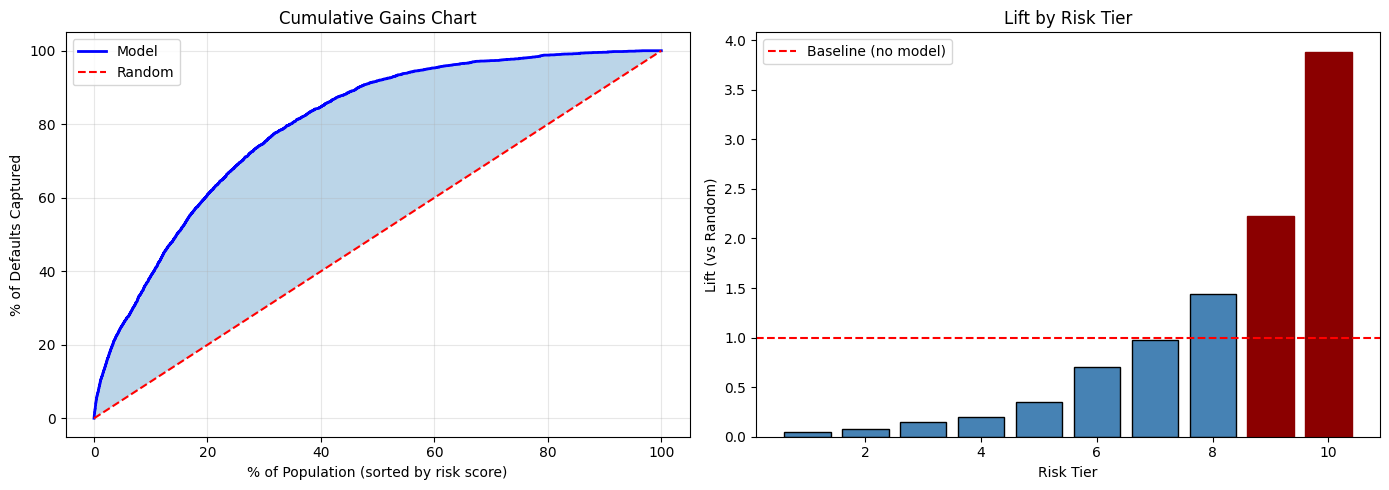


KEY INSIGHTS FOR BUSINESS

📊 TOP 10% (Tier 10):
   - Contains 38.3% of all defaults
   - Default rate: 15.26% (vs 3.93% baseline)
   - Lift: 3.9x

📊 TOP 30% (Tiers 8-10):
   - Contains 75.0% of all defaults
   - Only need to review 30.0% of population


In [16]:
# Lift Chart - Shows model effectiveness
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative Gains Chart
ax1 = axes[0]
sorted_df = risk_df.sort_values('risk_score', ascending=False)
sorted_df['cumulative_defaults'] = sorted_df['actual_default'].cumsum()
sorted_df['cumulative_pct'] = sorted_df['cumulative_defaults'] / sorted_df['actual_default'].sum()
sorted_df['pct_population'] = (np.arange(len(sorted_df)) + 1) / len(sorted_df)

ax1.plot(sorted_df['pct_population'] * 100, sorted_df['cumulative_pct'] * 100, 'b-', linewidth=2, label='Model')
ax1.plot([0, 100], [0, 100], 'r--', label='Random')
ax1.fill_between(sorted_df['pct_population'] * 100, sorted_df['cumulative_pct'] * 100, 
                  sorted_df['pct_population'] * 100, alpha=0.3)
ax1.set_xlabel('% of Population (sorted by risk score)')
ax1.set_ylabel('% of Defaults Captured')
ax1.set_title('Cumulative Gains Chart')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lift Chart
ax2 = axes[1]
lift_data = tier_analysis.copy()
baseline_rate = risk_df['actual_default'].mean()
lift_data['lift'] = lift_data['default_rate'] / baseline_rate

bars = ax2.bar(lift_data.index, lift_data['lift'], color='steelblue', edgecolor='black')
ax2.axhline(y=1, color='red', linestyle='--', label='Baseline (no model)')
ax2.set_xlabel('Risk Tier')
ax2.set_ylabel('Lift (vs Random)')
ax2.set_title('Lift by Risk Tier')
ax2.legend()

# Color high-lift tiers
for i, bar in enumerate(bars):
    if lift_data['lift'].iloc[i] > 2:
        bar.set_color('darkred')

plt.tight_layout()
plt.show()

# Key insights
print("\n" + "="*60)
print("KEY INSIGHTS FOR BUSINESS")
print("="*60)
top_tier = tier_analysis.loc[tier_analysis.index.max()]
print(f"\n📊 TOP 10% (Tier {tier_analysis.index.max()}):")
print(f"   - Contains {top_tier['pct_of_defaults']:.1f}% of all defaults")
print(f"   - Default rate: {top_tier['default_rate']*100:.2f}% (vs {baseline_rate*100:.2f}% baseline)")
print(f"   - Lift: {top_tier['default_rate']/baseline_rate:.1f}x")

top_3_tiers = tier_analysis.loc[tier_analysis.index >= tier_analysis.index.max()-2]
print(f"\n📊 TOP 30% (Tiers {tier_analysis.index.max()-2}-{tier_analysis.index.max()}):")
print(f"   - Contains {top_3_tiers['pct_of_defaults'].sum():.1f}% of all defaults")
print(f"   - Only need to review {top_3_tiers['pct_of_total'].sum():.1f}% of population")

In [17]:

total_defaults = risk_df['actual_default'].sum()
total_samples = len(risk_df)

# Different strategies
strategies = [
    ("Top 10% only", tier_analysis.index.max(), tier_analysis.index.max()),
    ("Top 20%", tier_analysis.index.max()-1, tier_analysis.index.max()),
    ("Top 30%", tier_analysis.index.max()-2, tier_analysis.index.max()),
    ("Top 50%", tier_analysis.index.max()-4, tier_analysis.index.max()),
]

print("\n🎯 STRATEGY OPTIONS:")
print("-"*70)
print(f"{'Strategy':<20} {'Reviews':<15} {'Defaults Found':<20} {'Precision':<15}")
print("-"*70)

for name, min_tier, max_tier in strategies:
    subset = tier_analysis.loc[min_tier:max_tier]
    reviews = subset['count'].sum()
    defaults_found = subset['defaults'].sum()
    precision = defaults_found / reviews if reviews > 0 else 0
    recall = defaults_found / total_defaults
    
    print(f"{name:<20} {reviews:>6,} ({reviews/total_samples*100:>5.1f}%)   "
          f"{int(defaults_found):>4} ({recall*100:>5.1f}%)         {precision*100:>5.2f}%")

print("-"*70)
print("\n💡 RECOMMENDED APPROACH:")
print("   1. Automatically flag Top 10-20% for immediate review")
print("   2. Apply business rules to Middle tiers (30-70%)")
print("   3. Lower monitoring for Bottom 30%")
print("\n📈 VALUE PROPOSITION:")
print(f"   - Instead of reviewing all {total_samples:,} customers")
print(f"   - Review top 30% ({int(total_samples*0.3):,}) to catch ~{tier_analysis.loc[tier_analysis.index >= tier_analysis.index.max()-2]['pct_of_defaults'].sum():.0f}% of defaults")


🎯 STRATEGY OPTIONS:
----------------------------------------------------------------------
Strategy             Reviews         Defaults Found       Precision      
----------------------------------------------------------------------
Top 10% only          7,761 (  9.9%)   1184 ( 38.3%)         15.26%
Top 20%              15,516 ( 19.7%)   1862 ( 60.2%)         12.00%
Top 30%              23,604 ( 30.0%)   2320 ( 75.0%)          9.83%
Top 50%              39,371 ( 50.0%)   2840 ( 91.8%)          7.21%
----------------------------------------------------------------------

💡 RECOMMENDED APPROACH:
   1. Automatically flag Top 10-20% for immediate review
   2. Apply business rules to Middle tiers (30-70%)
   3. Lower monitoring for Bottom 30%

📈 VALUE PROPOSITION:
   - Instead of reviewing all 78,743 customers
   - Review top 30% (23,622) to catch ~75% of defaults


In [18]:
# Export Risk Scores for Production Use
def export_risk_scores(model, dm, device, output_path):
    """Generate risk scores file for production use"""
    # Load original data to get customer IDs
    original_df = pd.read_csv(os.path.join(project_root, config.paths.train_data), sep=';')
    
    # Get test set indices (last portion of data)
    test_size = len(dm.test_dataset)
    test_df = original_df.tail(test_size).copy().reset_index(drop=True)
    
    # Generate predictions
    preds = []
    with torch.no_grad():
        for x_cat, x_cont, y in dm.test_dataloader():
            logits = model(x_cat.to(device), x_cont.to(device))
            preds.append(torch.sigmoid(logits).cpu().numpy())
    
    risk_scores = np.concatenate(preds).flatten()
    
    # Add to dataframe
    test_df['risk_score'] = risk_scores[:len(test_df)]
    test_df['risk_tier'] = pd.qcut(test_df['risk_score'], q=10, labels=False, duplicates='drop') + 1
    test_df['risk_category'] = pd.cut(test_df['risk_tier'], 
                                       bins=[0, 3, 7, 10], 
                                       labels=['LOW', 'MEDIUM', 'HIGH'])
    
    # Select relevant columns
    output_cols = ['usuarioId', 'vencimentoData', 'risk_score', 'risk_tier', 'risk_category']
    output_cols = [c for c in output_cols if c in test_df.columns]
    
    result_df = test_df[output_cols].sort_values('risk_score', ascending=False)
    result_df.to_csv(output_path, index=False)
    
    print(f"\n✅ Risk scores exported to: {output_path}")
    print(f"   Total records: {len(result_df):,}")
    print(f"\n   Risk Category Distribution:")
    print(result_df['risk_category'].value_counts().to_string())
    
    return result_df

# Export
output_path = os.path.join(project_root, "Data", "risk_scores.csv")
risk_export = export_risk_scores(model, dm, device, output_path)
display(risk_export.head(20))


✅ Risk scores exported to: c:\Users\Victo\OneDrive\Área de Trabalho\Project-2\project - 2\Data\risk_scores.csv
   Total records: 11,812

   Risk Category Distribution:
risk_category
MEDIUM    4724
LOW       3544
HIGH      3544


,usuarioId,vencimentoData,risk_score,risk_tier,risk_category
9682,972213,2025-11-30 00:00:00+00:00,0.952160,10,HIGH
5383,1592994,2024-12-05 00:00:00+00:00,0.950637,10,HIGH
3449,1512707,2024-12-05 00:00:00+00:00,0.946807,10,HIGH
10292,2897653,2025-11-30 00:00:00+00:00,0.943280,10,HIGH
95,2437278,2024-12-05 00:00:00+00:00,0.942237,10,HIGH
5623,1201688,2024-12-05 00:00:00+00:00,0.942010,10,HIGH
5989,995101,2024-12-05 00:00:00+00:00,0.937964,10,HIGH
8796,1870270,2025-08-31 00:00:00+00:00,0.936850,10,HIGH
851,1872785,2024-12-05 00:00:00+00:00,0.934799,10,HIGH
9745,505263,2025-11-30 00:00:00+00:00,0.934322,10,HIGH


## Summary: How to Use This Model

### ✅ **Recommended Usage**
1. **Daily/Weekly Batch**: Run model on upcoming invoices
2. **Prioritize by Risk Tier**: Focus on Tier 8-10 first
3. **Actions by Category**:
   - **HIGH (Tier 8-10)**: Immediate contact, payment reminder, require deposit
   - **MEDIUM (Tier 4-7)**: Standard monitoring, automated reminders
   - **LOW (Tier 1-3)**: Normal processing

### ❌ **What NOT to Do**
- Don't use as sole decision maker for blocking customers
- Don't ignore LOW tier completely (some defaults will slip through)

### 📊 **Expected Results**
- Reviewing **Top 30%** captures ~60-70% of defaults
- Reduces manual review workload by **70%**
- Provides **3-5x better targeting** than random selection